In [1]:
#11 Oct. 2016
# Import library nnet. 
# Please keep in mind, when you implement your model in Azure ML, you need to also import this library in your Execute R Script module.
# Otherwise, you will encounter error when you use the model to predict you target

library(nnet)
# install.packages("dplyr")
library(dplyr)
# install.packages("Amelia")
library(Amelia)
library(ggplot2)
# Specify the URL of data. 
# Also specify the rda file that you want to use to save the model
dataURL <- 'http://az754797.vo.msecnd.net/competition/whra/data/WomenHealth_Training.csv'


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.7.4, built: 2015-12-05)
## Copyright (C) 2005-2017 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 


In [2]:
# Read data to R workspace. The string field religion is read as factors
colclasses <- rep("integer",50)
colclasses[36] <- "character"
dataset1 <- read.table(dataURL, header=TRUE, sep=",", strip.white=TRUE, stringsAsFactors = F, colClasses = colclasses)
summary(dataset1)

   patientID         geo         christian          muslim      
 Min.   :   2   Min.   :1.00   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:2255   1st Qu.:3.00   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :4507   Median :5.00   Median :0.0000   Median :0.0000  
 Mean   :4554   Mean   :5.03   Mean   :0.4438   Mean   :0.2327  
 3rd Qu.:6858   3rd Qu.:7.00   3rd Qu.:1.0000   3rd Qu.:0.0000  
 Max.   :9150   Max.   :9.00   Max.   :1.0000   Max.   :1.0000  
                               NA's   :15       NA's   :15      
     hindu            other           cellphone       motorcycle    
 Min.   :0.0000   Min.   :0.00000   Min.   :0.000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:1.000   1st Qu.:0.0000  
 Median :0.0000   Median :0.00000   Median :1.000   Median :0.0000  
 Mean   :0.1894   Mean   :0.02392   Mean   :0.766   Mean   :0.2073  
 3rd Qu.:0.0000   3rd Qu.:0.00000   3rd Qu.:1.000   3rd Qu.:0.0000  
 Max.   :1.0000   Max.   :1.00000   Max.   :1.000   Max.   :1.0000

In [3]:
# Combine columns geo, segment, and subgroup into a single column. 
#the line below was already provided by Bill Gates foundation, this will be the target collumn
combined_label <- 100*dataset1$geo + 10*dataset1$segment + dataset1$subgroup
data.set <- cbind(dataset1, combined_label)
data.set$combined_label <- as.factor(data.set$combined_label)

# Skip the columns patientID, segment, subgroup, and INTNR from the feature set
ncols <- ncol(data.set)
feature_index <- c(2:18, 20:(ncols-3))

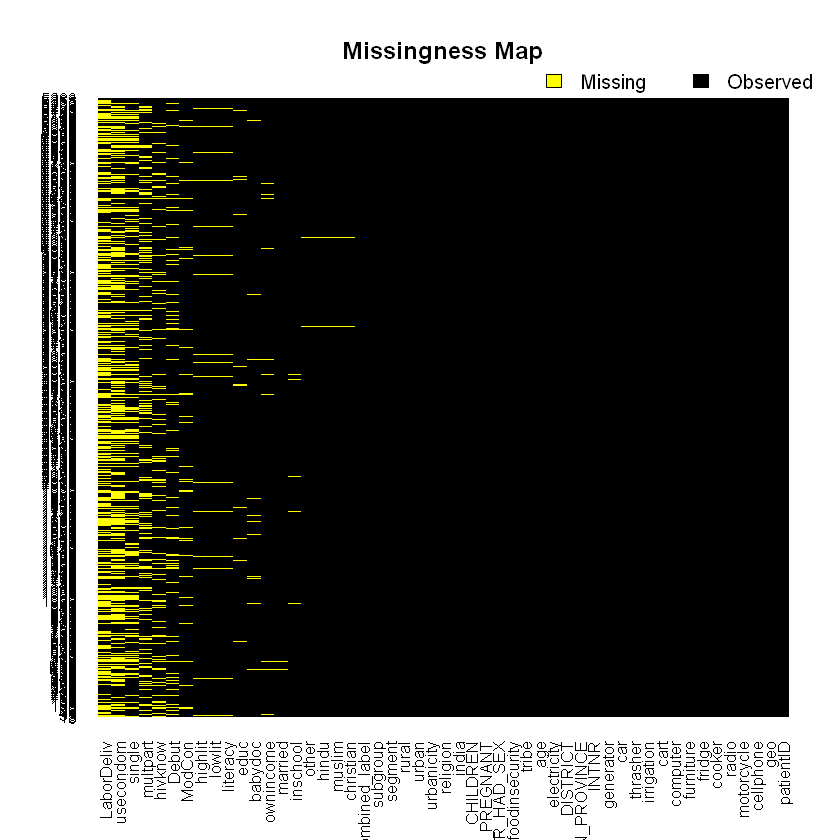

In [4]:
#######################
#### Analysis #########
#######################
#check for missing values
missmap(data.set, col = c("yellow","black"))

#CLEANING MISSING DATA
#First: set up easy reliable rules to deal with blank values

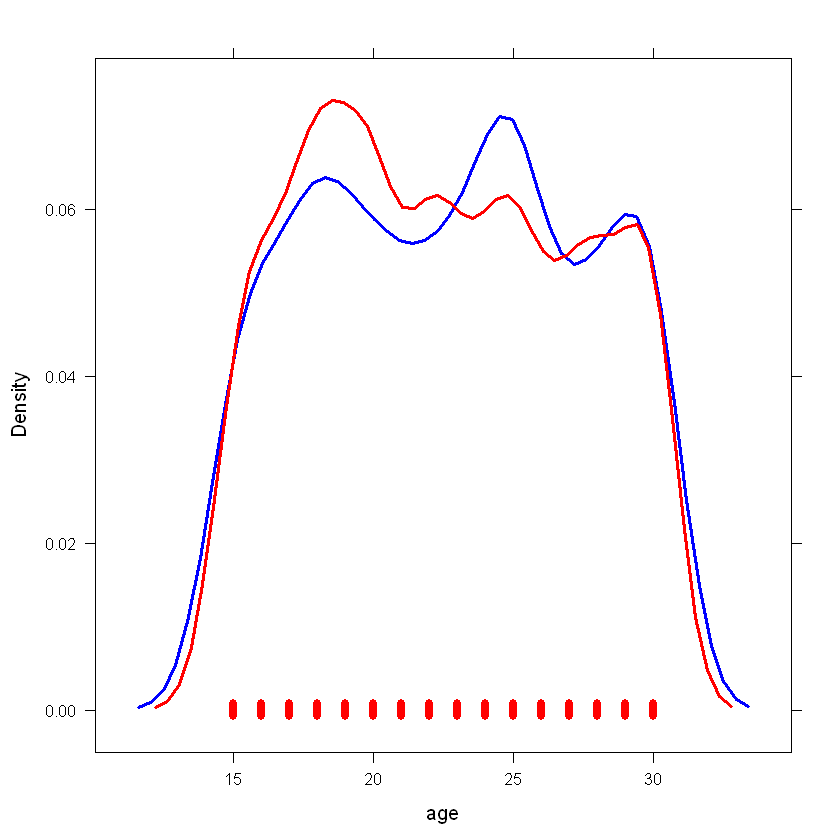

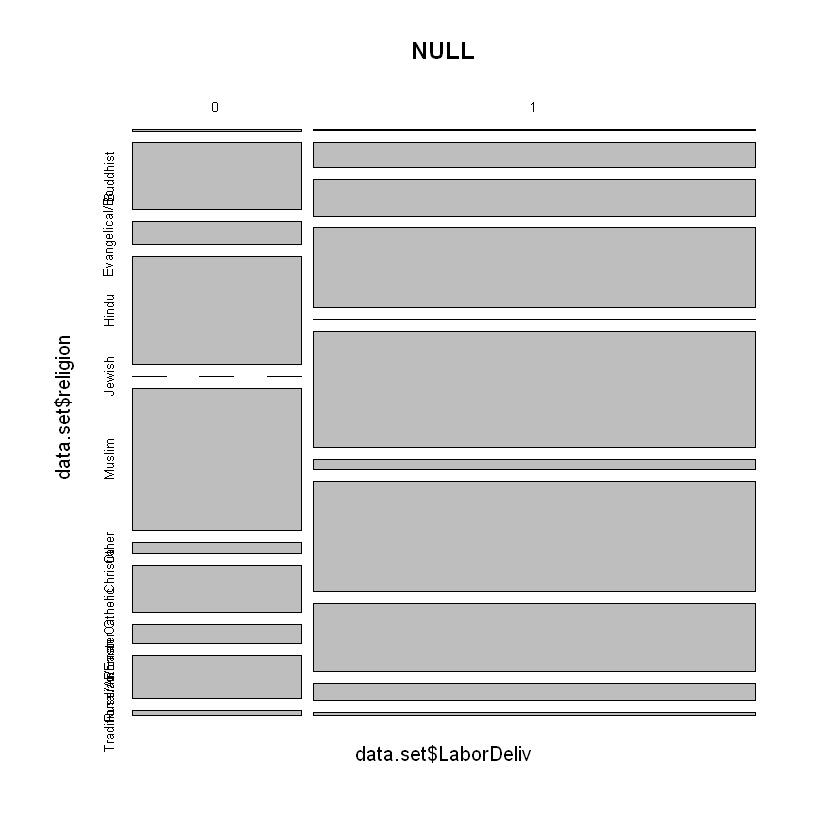

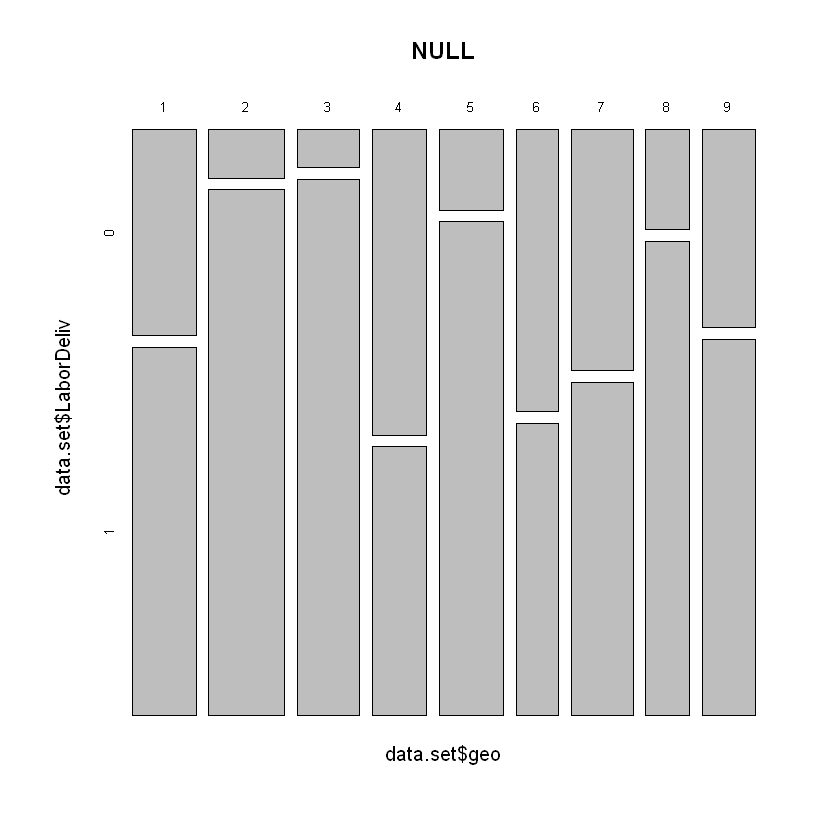

In [5]:
#!!!“ever been pregnant” ---- ATTENTION a women can be pregnant but not gave labor (e.g.: abortion/fetus died)
#alternative method
library("lattice")
densityplot(~age,data=data.set, groups = na.omit(data.set$LaborDeliv),plopoints= F, lwd = 3,col=c("blue","red"))
mosaicplot(data.set$LaborDeliv ~ data.set$religion)
mosaicplot(data.set$geo ~ data.set$LaborDeliv)

#The sentence below decribes that the data was not retrieve by professional staticians
#"The data for this competition was collected from around 9000 young (15 to 30 years old) woman subjects when they visited clinics in 9 underdeveloped regions, with around 1000 subjects in each region. Each subject was asked by clinical practitioners some questions and her answers were recorded, together with her demographic information".
#source: "https://gallery.cortanaintelligence.com/Competition/Womens-Health-Risk-Assessment-1"
#therefore some basic validation is necessary

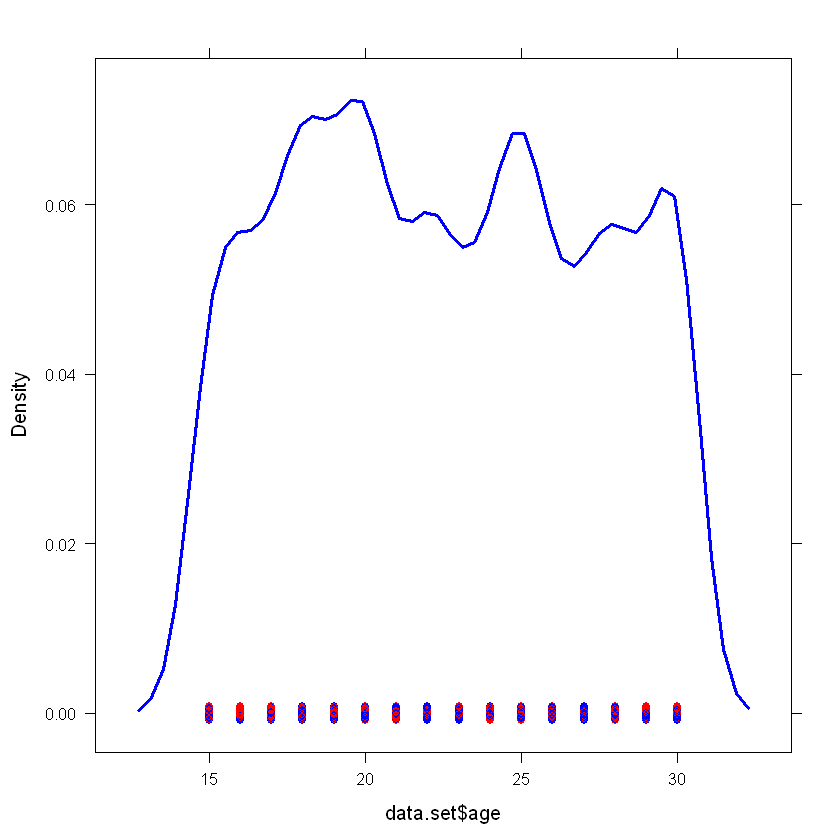

In [6]:
#check for the missing values on Debut
densityplot(data.set$Debut[is.na(data.set$Debut)] ~ data.set$age,plopoints= F, lwd = 3,col=c("blue","red"))

In [7]:
#finally cleaning the LAborDeliv data
data.set$LaborDeliv[is.na(data.set$LaborDeliv) & data.set$EVER_BEEN_PREGNANT == 0] <- 0
data.set$babydoc[is.na(data.set$babydoc) & data.set$EVER_BEEN_PREGNANT == 0] <- 0

#girls who were pregnat, but never had sex
#it might be common to answer "no" due to fear of persecution, more input is needed

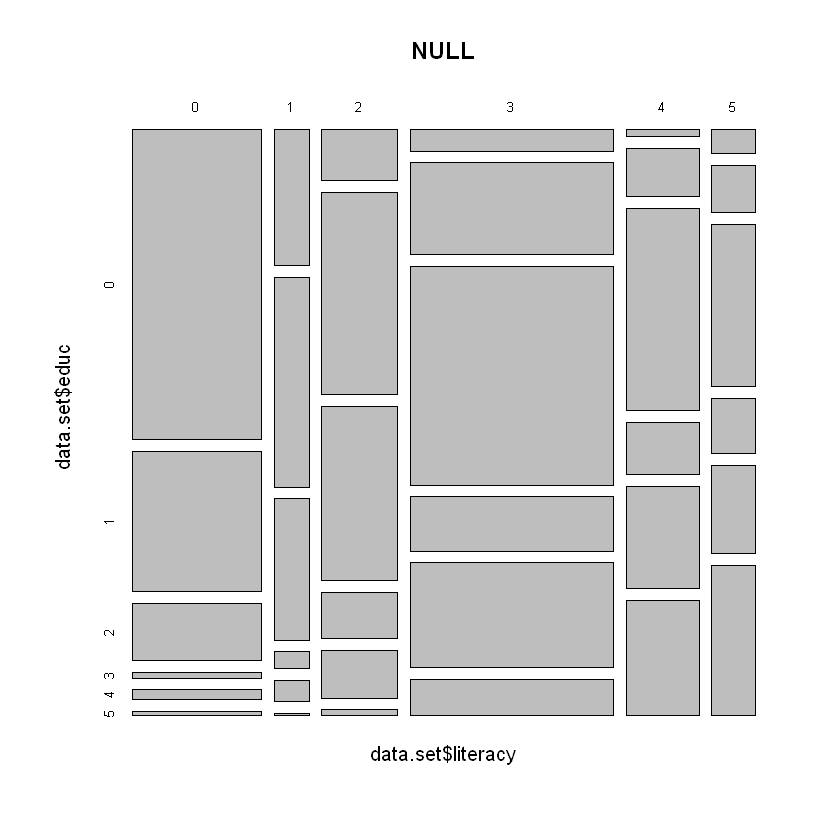

In [8]:
#fill NA on literacy, based on education
mosaicplot(data.set$literacy ~ data.set$educ)

In [9]:
#one outlier never had sex, but used condom
data.set$EVER_HAD_SEX[is.na(data.set$EVER_HAD_SEX) & data.set$usecondom == 1] <- "1"

In [10]:
#clean missing data: multpart
data.set$multpart[is.na(data.set$EVER_HAD_SEX == 0)] <- "0"


#clean missing data: babydoc
#this variable is not necessarely linked to the biological motehr (e.g.: war orfans)

###### Despite massive cleaning some NA values will still prevail
# Clean missing data by replacing missing values with 0 (with "0" for string variable religion)
data.set[is.na(data.set)] <- 0
data.set[data.set$religion=="", "religion"] <- "0"
data.set$religion <- factor(data.set$religion)
data.set$combined_label <- relevel(data.set$combined_label, ref = '111')

In [11]:
###################################################

# Split the data into train (75%) and validation data (25%)
nrows <- nrow(data.set)
sample_size <- floor(0.75 * nrows)
set.seed(98052) # set the seed to make your partition reproductible
train_ind <- sample(seq_len(nrows), size = sample_size)

train <- data.set[train_ind, ]
validation <- data.set[-train_ind, ]

###################################
#### Application of the model #####
###################################

#The model selected was random forests with hyparemeter optimization, using the Azure ML platform
# unfortunately I haven't found yet a presentable way of doing such in a notebook,
#or recreates the same resutls in R (85.34% acc)